In [1]:
# !unzip -q '/content/drive/MyDrive/flowers/flowers.zip' -d '/content/flowers'

In [2]:
import os
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import statistics
import random
import numpy as np

In [3]:
image_size = 32
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
print(os.getcwd())
DATA_DIR = 'jpg'

print(os.listdir(DATA_DIR))

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor()]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
z_dim = 20

C:\Users\shiva\Desktop\projects\Generative Networks
['flowers']
cuda


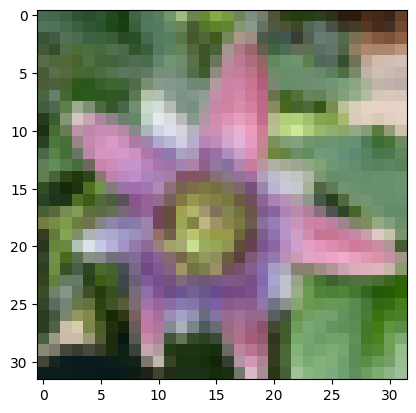

In [4]:
img = train_ds[101][0]
plt.imshow(img.permute(1, 2, 0))

# GENERATOR - DISCRIMINATOR

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()

        self.main = nn.Sequential(
            # 3 x 32 x 32
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(0.2, inplace=True),
#             # 32 x 32 x 32
#             nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 16 x 16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 8 x 8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 4 x 4
            nn.Conv2d(256, latent_size, kernel_size=4, stride=1, padding=0, bias=False),
            # latent_size x 1 x 1
            nn.Flatten(),
#             nn.Linear(3072, 1000),
#             nn.Linear(1000, latent_size),
#             nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()

        self.main = nn.Sequential(
            # latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 256 x 4 x 4
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 8 x 8
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64 x 16 x 16
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             # 32 x 32 x 32
#             nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(3),
#             nn.ReLU(True),
            # 3 x 32 x 32
#             nn.Linear(latent_size, 1000),
#             nn.Linear(1000, 3072),
#             nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x)

In [7]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.img_to_mu = Encoder(z_dim).to(device)
        self.img_to_sigma = Encoder(z_dim).to(device)
        
        self.decoder = Decoder(z_dim).to(device)

    def forward(self, x):
        mu = self.img_to_mu(x)
        sigma = self.img_to_sigma(x)
        
        epsilon = torch.rand_like(sigma)
        
        z_recons = mu + sigma * epsilon
        z_recons = z_recons[:, :, None, None]
        
        x_recons = self.decoder(z_recons)
        return x_recons, mu, sigma
    
model = VAE(z_dim = z_dim).to(device)

In [8]:
latent = torch.randn(batch_size, 3, 32, 32, device=device)
fake_images = model(latent)
print(latent.size(), fake_images[0].size())

torch.Size([16, 3, 32, 32]) torch.Size([16, 3, 32, 32])


#TRAINING

In [9]:
def fit(epochs, lr):
    
    loss_criteria = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    torch.cuda.empty_cache()
    
    for epoch in range(epochs):
        losses = []
        for real_images, _ in tqdm(train_dl):
            
            real_images = real_images.to(device)
            recons, mu, sigma = model(real_images)
            
            recons_loss = loss_criteria(recons, real_images)
            kl_div_loss = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
#             break
            
            total_loss = recons_loss + kl_div_loss
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            losses.append(total_loss.item())
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss: {:6f}".format(epoch+1, epochs, sum(losses)))
        i = random.randint(1, 1000)
        real_img = train_ds[i][0].to(device).flatten()
        real_img = real_img.unsqueeze(0)
        img, mu, sigma = model(real_img)
        image = img.squeeze().cpu().detach().numpy()
        image = np.reshape(image, (32, 32, 3))
        plt.imshow(image)
        plt.show()
              
        
    return losses

In [ ]:
epochs = 100
lr = 0.00003
history = fit(epochs, lr)

  0%|          | 0/512 [00:00<?, ?it/s]

hi
hi2


torch.Size([1, 20])
torch.Size([1, 20])


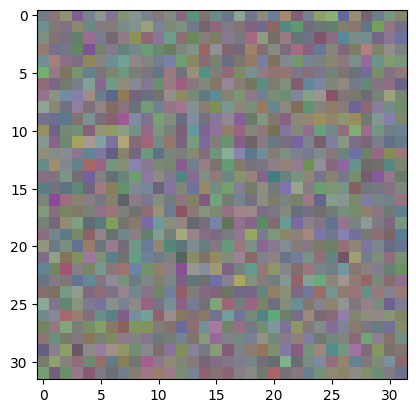

In [104]:
i = random.randint(1, 1000)
real_img = train_ds[i][0].to(device).flatten()
real_img = real_img.unsqueeze(0)
img, mu, sig = model(real_img)
image = img.squeeze().cpu().detach().numpy()
image = np.reshape(image, (32, 32, 3))
plt.imshow(image)
plt.show()

In [75]:
x_recons = torch.randn(16, 3072)

# Define symbolic integers
batch_size = 16
channels = 3
height = 32
width = 32

# Reshape the array using symbolic integers
x_recons = x_recons.reshape((batch_size, channels, height, width))

In [77]:
x_recons.size()

torch.Size([16, 3, 32, 32])